# Part II - Prosper Loan Data Exploration
## by Lekan Adenusi

## Investigation Overview
In my presentation I focus on how the loaned amount, prosper rating, credit scores, and the income range affect the Annual Percentage Rate or APR (the rate charged on the original loan annually) of the loan, as well as the exciting interactions observed between them. There are no major changes to the visualizations used during the exploratory phase.

## Dataset Overview
The dataset used for this project is the Prosper Loan Data provided by Udacity. It contains over 100,000 loans with 81 attributes. Only few of these features were considered, and in this presentation I narrow my focus to the useful ones.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# select all variables of interest
cols_of_interest = ['BorrowerAPR', 'CreditScoreRangeUpper', 'CreditScoreRangeLower',
                    'ProsperRating (Alpha)', 'LoanOriginalAmount', 'IncomeRange', 'StatedMonthlyIncome']

# load in the dataset into a pandas dataframe
loan_df = pd.read_csv('prosperLoanData.csv', usecols=cols_of_interest)

# Create ordered prosper ratings
categorical_prosper_rating = pd.CategoricalDtype(categories=['HR', 'E', 'D', 'C', 'B', 'A', 'AA'], ordered=True)
loan_df['ProsperRating (Alpha)'] = loan_df['ProsperRating (Alpha)'].astype(categorical_prosper_rating)

# Filter data based on the 99.9th percentile
percentile_99_9 = loan_df['StatedMonthlyIncome'].quantile(0.999)
loan_df =  loan_df[ loan_df['StatedMonthlyIncome'] <= percentile_99_9 ]

# Filter out the following income ranges and make the income ranges ordered
loan_df = loan_df[ ~loan_df['IncomeRange'].isin(['Not employed', 'Not displayed']) ]
income_range_ordered = pd.CategoricalDtype(['$0', '$1-24,999', '$25,000-49,999',
                                            '$50,000-74,999', '$75,000-99,999','$100,000+'], ordered=True)
loan_df['IncomeRange'] = loan_df['IncomeRange'].astype(income_range_ordered)

# Finally create partitions for the loan amounts and make them ordered as well
def bin_loan_amount(amount):
    if amount >= 1000 and amount <= 5000:
        return '1-5K'
    elif amount > 5000 and amount <= 15000:
        return '5-15K'
    else:
        return '>15K'
    
loan_df['LoanAmountBin'] = loan_df['LoanOriginalAmount'].apply(lambda x: bin_loan_amount(x))
cat_loan_bin = pd.CategoricalDtype(['1-5K', '5-15K', '>15K'], ordered=True)
loan_df['LoanAmountBin'] = loan_df['LoanAmountBin'].astype(cat_loan_bin)

In [3]:
# create a function to remove spines from axes objects
def remove_spines(ax, which=['right', 'top']):
    for spine in which:
        ax.spines[spine].set_visible(False)

## Distribution of APR and Loan Amounts
I begin by considering the distribution of the APR and the loan amounts using a histogram. Here we see the distribution of the APR is almost normal but not quite so; it also has most of its values between 0.1 and 0.4.

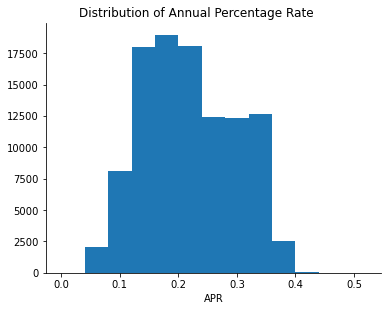

In [4]:
fig, ax = plt.subplots(figsize=(6, 4.6))

bins = np.arange(0, 0.53, 0.04)
ax.hist(loan_df['BorrowerAPR'], bins=bins)

# set labels and title
ax.set_xlabel('APR')
ax.set_title('Distribution of Annual Percentage Rate', x=0.45)

# remove spines
remove_spines(ax);

## Distribution of Selected Features
Let us consider the loan amounts first. We see that the spikes in the distribution reveal that most loans are usually procured in multiples of 1,000. Besides the occasional spikes, the distribution of the loan amounts is right-skewed with relatively only few amounts around 20k USD and above. Also, both credit scores have a similar distribution, suggesting that that both values are related by some constant.

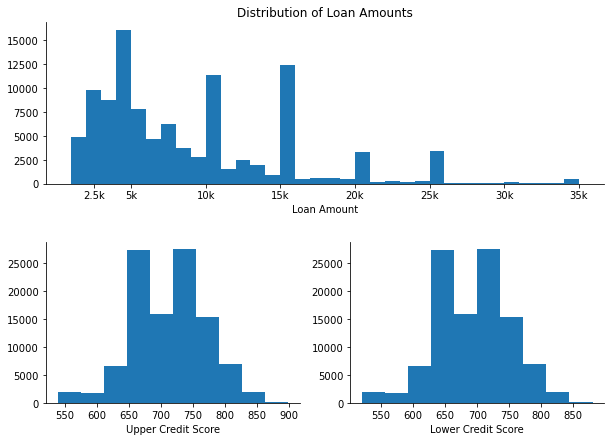

In [5]:
fig = plt.figure(figsize=(10, 7))
spec = fig.add_gridspec(2, 2)

ax10 = fig.add_subplot(spec[0, :])
ax20 = fig.add_subplot(spec[1, 0])
ax21 = fig.add_subplot(spec[1, 1])

bins = np.arange(1000, 36000, 1000)
ax10.hist(loan_df['LoanOriginalAmount'], bins=bins)
ax10.set_title('Distribution of Loan Amounts')
ax10.set_xlabel('Loan Amount')
ax10.set_xticks([2.5e3, 5e3, 10e3, 15e3, 20e3, 25e3, 30e3, 35e3], ['2.5k', '5k', '10k', '15k', '20k', '25k', '30k', '35k'])
remove_spines(ax10)

ax20.hist(loan_df['CreditScoreRangeUpper'])
ax20.set_xlabel('Upper Credit Score')
remove_spines(ax20)

ax21.hist(loan_df['CreditScoreRangeLower'])
ax21.set_xlabel('Lower Credit Score')
remove_spines(ax21)

plt.subplots_adjust(hspace=0.36);

## Visualizing Correlations Between Variables
To start off with exploring the relationships between my features and the APR, let's see a correlation plot. There's a negative correlation between all three variables and the APR, although they are only moderate. This indicates that as these features become larger, the APR becomes smaller.



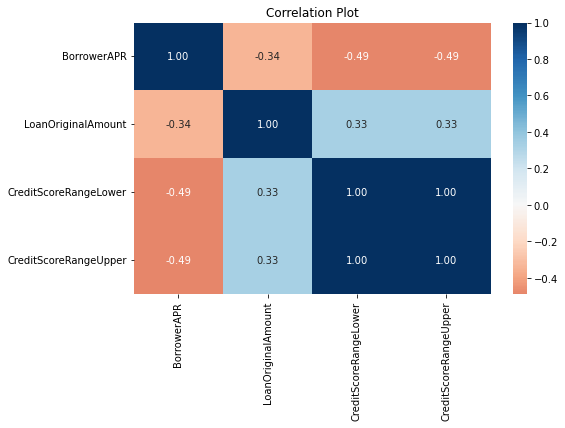

In [6]:
numeric_vars = ['BorrowerAPR', 'LoanOriginalAmount', 'CreditScoreRangeLower', 
                'CreditScoreRangeUpper']

corr = loan_df[numeric_vars].corr()
plt.figure(figsize = [8, 5])
sns.heatmap(corr,
            annot = True,
            fmt = '.2f',
            cmap='RdBu',
            center = 0)

plt.title('Correlation Plot');

## Effect of Loan Amount on the APR
An interesting insight is revealed here. The boxplots show that high loan amounts, on general, incure relatively lower APR, and vice versa. Also, notice that the group 1-5K has the highest variance, while the group > 15K has the lowest variance. This shows that smaller loans have a more variable APR, compared to higher amounts of loans. In the second plot, the data was aggregated by its mean, and we see again how the line slopes down, supporting our observation from the boxplot.


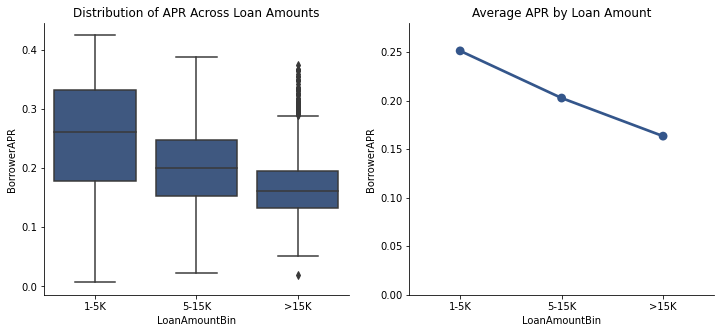

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
color = '#34568B'

sns.boxplot(x='LoanAmountBin',
            y='BorrowerAPR',
            data=loan_df,
            color=color,
            ax=ax1)
ax1.set_title('Distribution of APR Across Loan Amounts')
remove_spines(ax1)

sns.pointplot(x='LoanAmountBin',
              y='BorrowerAPR',
              data=loan_df,
              estimator=np.mean,
              ax=ax2,
              color=color)
ax2.set_title('Average APR by Loan Amount')
ax2.set_ylim( [0, 0.28] )
remove_spines(ax2);

## Distribution of Borrower APR by Prosper Rating
There is a clear distinction in the distribution of the Borrower APR across the prosper ratings. Interestingly the median APR increases as the prosper rating becomes worse. I have also removed the outliers to keep the plot from being too busy. In the next slide we'll dig further into how the loan amount varies across the prosper ratings. 

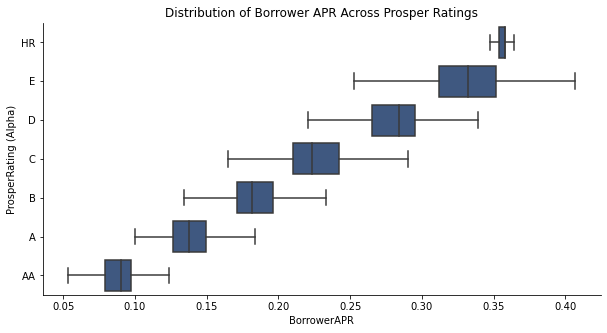

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(y='ProsperRating (Alpha)',
            x='BorrowerAPR',
            data=loan_df,
            ax=ax,
            color=color,
            sym='')
ax.set_title('Distribution of Borrower APR Across Prosper Ratings')
remove_spines(ax);

## Distribution of Loan Amounts Across Prosper Ratings
For now though, let's check the distribution of the loan amounts across the prosper rating. We'll see that the better the prosper rating, the higher the variance in the amounts loaned out. A vertical line has been drawn at a loan amount of 15,000 for emphasis. Remember that loans greater than 15K generally have a smaller APR and also have a lower variance. From this boxplot, we see that loans greater than 15K are associated only with prosper ratings C, B, A, and AA. The APR for these prosper ratings also happens to vary less. This explains why the APR for loans higher than 15K has the least variance. This is an exciting interaction to keep in mind. Next, we'll examine how the income ranges compare across the prosper ratings.

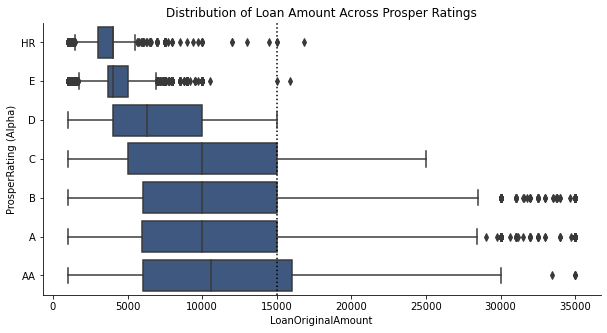

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(x='LoanOriginalAmount',
            y='ProsperRating (Alpha)',
            data=loan_df,
            color=color,
            ax=ax,
            zorder=2)
ax.set_title('Distribution of Loan Amount Across Prosper Ratings');
plt.axvline(15000, color='black', linestyle='dotted', zorder=1)
remove_spines(ax)

## What's the Proportion of Income Ranges Across Prosper Ratings?
The proportion of loanees earning high amounts increases as the Prosper score becomes better from left to right while the proportion of those earning lower, for example, between 1 and 25K USD decreases with increasing prosper rating, though this change is less pronounced compared to the former. To sum up, we'll look at the combined effect of loan amount and income range on the borrower APR.

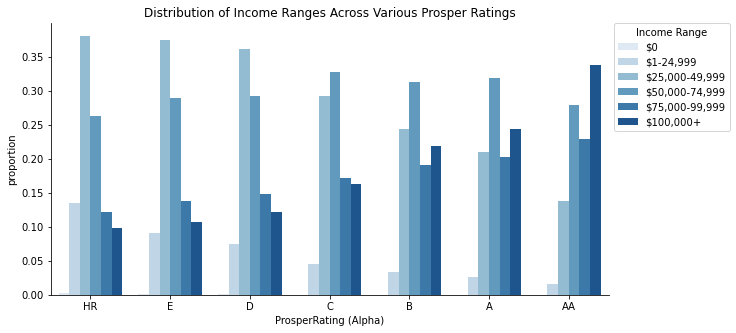

In [10]:
income_range_by_rating = loan_df.groupby(['ProsperRating (Alpha)'],
                                         as_index=False)['IncomeRange'].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=income_range_by_rating,
            x='ProsperRating (Alpha)',
            y='proportion',
            hue='IncomeRange',
            palette='Blues')
ax.set_title('Distribution of Income Ranges Across Various Prosper Ratings')
remove_spines(ax)

plt.legend(bbox_to_anchor=(1.0, 0.8), loc='center left', title='Income Range');

## Combined Effect of Income Range and Loan Amount on APR
We quickly notice a few things here. First, for loans greater than 15K, we can see how the APR becomes smaller as the income range increases. This same effect is noticeable in the loan range of 5-15K. However, it is the opposite for loans between 1-5K as the borrower APR is seen to increase (though not very much) for those on the higher end of the income range.

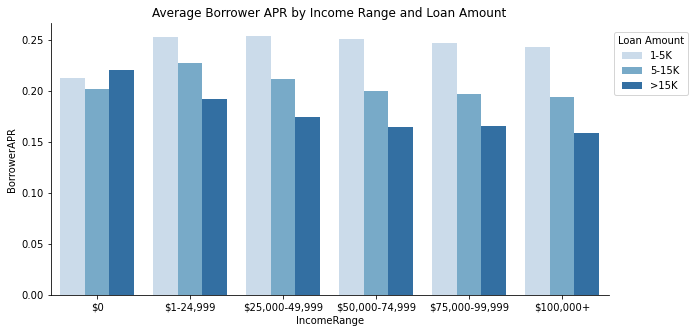

In [11]:
apr_by_income_and_loan = loan_df.groupby(['IncomeRange', 'LoanAmountBin'])['BorrowerAPR'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=apr_by_income_and_loan,
            x='IncomeRange',
            y='BorrowerAPR',
            hue='LoanAmountBin',
            ax=ax,
            palette='Blues')
ax.set_title('Average Borrower APR by Income Range and Loan Amount')
remove_spines(ax)

plt.legend(bbox_to_anchor=(1.0, 0.85), loc='center left', title='Loan Amount');

In [12]:
!jupyter nbconvert Part_II_Explanatory_Analysis.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_Explanatory_Analysis.ipynb to slides
[NbConvertApp] Writing 760133 bytes to Part_II_Explanatory_Analysis.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\72\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\72\anaconda3\lib\site-packages\jupyter_core\application.py", line 264, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\72\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\72\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 369, in start
    self.convert_notebooks()
  File "C:\Users\72\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 541, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  F